# <a id='toc1_'></a>[Notebook de modelisation](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Notebook de modelisation](#toc1_)    
  - [Imports des libs](#toc1_1_)    
  - [Fonction d'evaluation d'un modèle de clustering](#toc1_2_)    
- [Benchmark des models](#toc2_)    
  - [Liste des algorithmes à comparer](#toc2_1_)    
  - [Benchmark RFM](#toc2_2_)    
    - [Entrainement des modèle (Utilisation du multithreading)](#toc2_2_1_)    
      - [Find the best number of cluster (Plot metrics per number of cluster)](#toc2_2_1_1_)    
      - [Visualisation des clusters](#toc2_2_1_2_)    
        - [Vue 2D](#toc2_2_1_2_1_)    
        - [Vue 3D](#toc2_2_1_2_2_)    
  - [Benchmark RFMLS](#toc2_3_)    
    - [Entrainement des modèle (Utilisation du multithreading)](#toc2_3_1_)    
      - [Find the best number of cluster (Plot metrics per number of cluster)](#toc2_3_1_1_)    
      - [Visualisation des clusters](#toc2_3_1_2_)    
        - [Vue 2D](#toc2_3_1_2_1_)    
        - [Vue 3D](#toc2_3_1_2_2_)    
- [Entrainement du modèle selectioné](#toc3_)    
      - [Entrainement Kmeans](#toc3_1_1_1_)    
        - [Visualisation du modèle](#toc3_1_1_1_1_)    
- [Maintenace des Modèles](#toc4_)    
  - [Functions](#toc4_1_)    
  - [ARI RFM](#toc4_2_)    
    - [labels_true](#toc4_2_1_)    
    - [labels_pred](#toc4_2_2_)    
    - [Claculate ARI](#toc4_2_3_)    
    - [Plot ARI score /mois](#toc4_2_4_)    
  - [ARI RFM LS](#toc4_3_)    
        - [labels_true](#toc4_3_1_1_1_)    
        - [labels_pred](#toc4_3_1_1_2_)    
        - [Claculate ARI](#toc4_3_1_1_3_)    
    - [Plot ARI score /mois](#toc4_3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
# installation des dependances avec uv
# !uv pip install scikit-learn numpy hdbscan

## <a id='toc1_1_'></a>[Imports des libs](#toc0_)

In [ ]:
import pandas as pd
import numpy as np
from sklearn import cluster, metrics, mixture
from sklearn.datasets import make_blobs
import time
import hdbscan  # Pour HDBSCAN
from joblib import Parallel, delayed

## <a id='toc1_2_'></a>[Fonction d'evaluation d'un modèle de clustering](#toc0_)

In [ ]:
def evaluate_algorithm(name, algorithm, data):
    start_time = time.time()

    # Fit et prédire les labels
    labels = algorithm.fit_predict(data)
    elapsed_time = time.time() - start_time

    # Calcul des scores
    silhouette_score = (
        metrics.silhouette_score(data, labels) if len(set(labels)) > 1 else None
    )
    davies_bouldin_score = (
        metrics.davies_bouldin_score(data, labels) if len(set(labels)) > 1 else None
    )
    calinski_harabasz_score = (
        metrics.calinski_harabasz_score(data, labels) if len(set(labels)) > 1 else None
    )

    return {
        "Algorithm": name,
        "Time (s)": elapsed_time,
        "Silhouette Score": silhouette_score,
        "Davies-Bouldin Score": davies_bouldin_score,
        "Calinski-Harabasz Score": calinski_harabasz_score,
    }

# <a id='toc2_'></a>[Benchmark des models](#toc0_)

Les modèles de clustering dispo avec [sklearn](https://scikit-learn.org/stable/modules/clustering.html) et son tableau comparatif

## <a id='toc2_1_'></a>[Liste des algorithmes à comparer](#toc0_)

In [ ]:

n_cluster_value = 3
min_sample_value = 1000

model_list = {
    'kmeans': cluster.KMeans(n_clusters=n_cluster_value),
    'minibatchkmeans': cluster.MiniBatchKMeans(n_clusters=n_cluster_value),
    'hdbscan': hdbscan.HDBSCAN(min_cluster_size=min_sample_value),
    'gmm': mixture.GaussianMixture(n_components=n_cluster_value),
    'birch': cluster.Birch(n_clusters=n_cluster_value),
    'agglomerative': cluster.AgglomerativeClustering(n_clusters=n_cluster_value),
    'dbscan': cluster.DBSCAN(eps=0.5, min_samples=min_sample_value),
    'optics': cluster.OPTICS(min_samples=min_sample_value),
    'meanshift': cluster.MeanShift(),
}

## <a id='toc2_2_'></a>[Benchmark RFM](#toc0_)

In [134]:
# import des données
rfm = pd.read_excel('RFM.xlsx')
rfm = rfm.drop(['customer_unique_id', 'Segment'], axis=1).dropna()
rfm.head()

,Unnamed: 0,R,F,M
0,0,160,1,141.90
1,1,163,1,27.19
2,2,585,1,86.22
3,3,369,1,43.62
4,4,336,1,196.89


In [ ]:
# On prend 10% des données pour gagner du temps d'execution
rfm_sample = rfm.sample(frac=0.1, random_state=42)
print(rfm_sample.shape)

(9610, 4)


### <a id='toc2_2_1_'></a>[Entrainement des modèle (Utilisation du multithreading)](#toc0_)

In [136]:
results = []

# Exécution en parallèle avec joblib
results = Parallel(n_jobs=-1)(delayed(evaluate_algorithm)(name, algorithm, rfm_sample)for name, algorithm in model_list.items())

# Création d'un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results)

KeyboardInterrupt: 

In [ ]:
# Silhouette Score : Plus il est élevé, mieux c'est
# Davies-Bouldin Score : Plus il est faible, mieux c'est 
# Calinski-Harabasz Score : Plus il est élevé, mieux c'est

results_df.sort_values(by=['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'], ascending=[False, True, False])

,Algorithm,Time (s),Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,kmeans,0.184941,0.594251,0.496492,38798.587332
1,minibatchkmeans,0.153240,0.593642,0.496660,38755.330512
4,birch,2.921978,0.593267,0.496833,38681.787083
5,agglomerative,2.988251,0.593267,0.496833,38681.787083
8,meanshift,48.430716,0.538532,0.503872,27050.627977
2,hdbscan,1.211223,0.268693,2.957781,3581.393659
3,gmm,0.204263,-0.003197,125.545456,0.455005
6,dbscan,0.067115,NaN,NaN,NaN
7,optics,7.203142,NaN,NaN,NaN


#### <a id='toc2_2_1_1_'></a>[Find the best number of cluster (Plot metrics per number of cluster)](#toc0_)

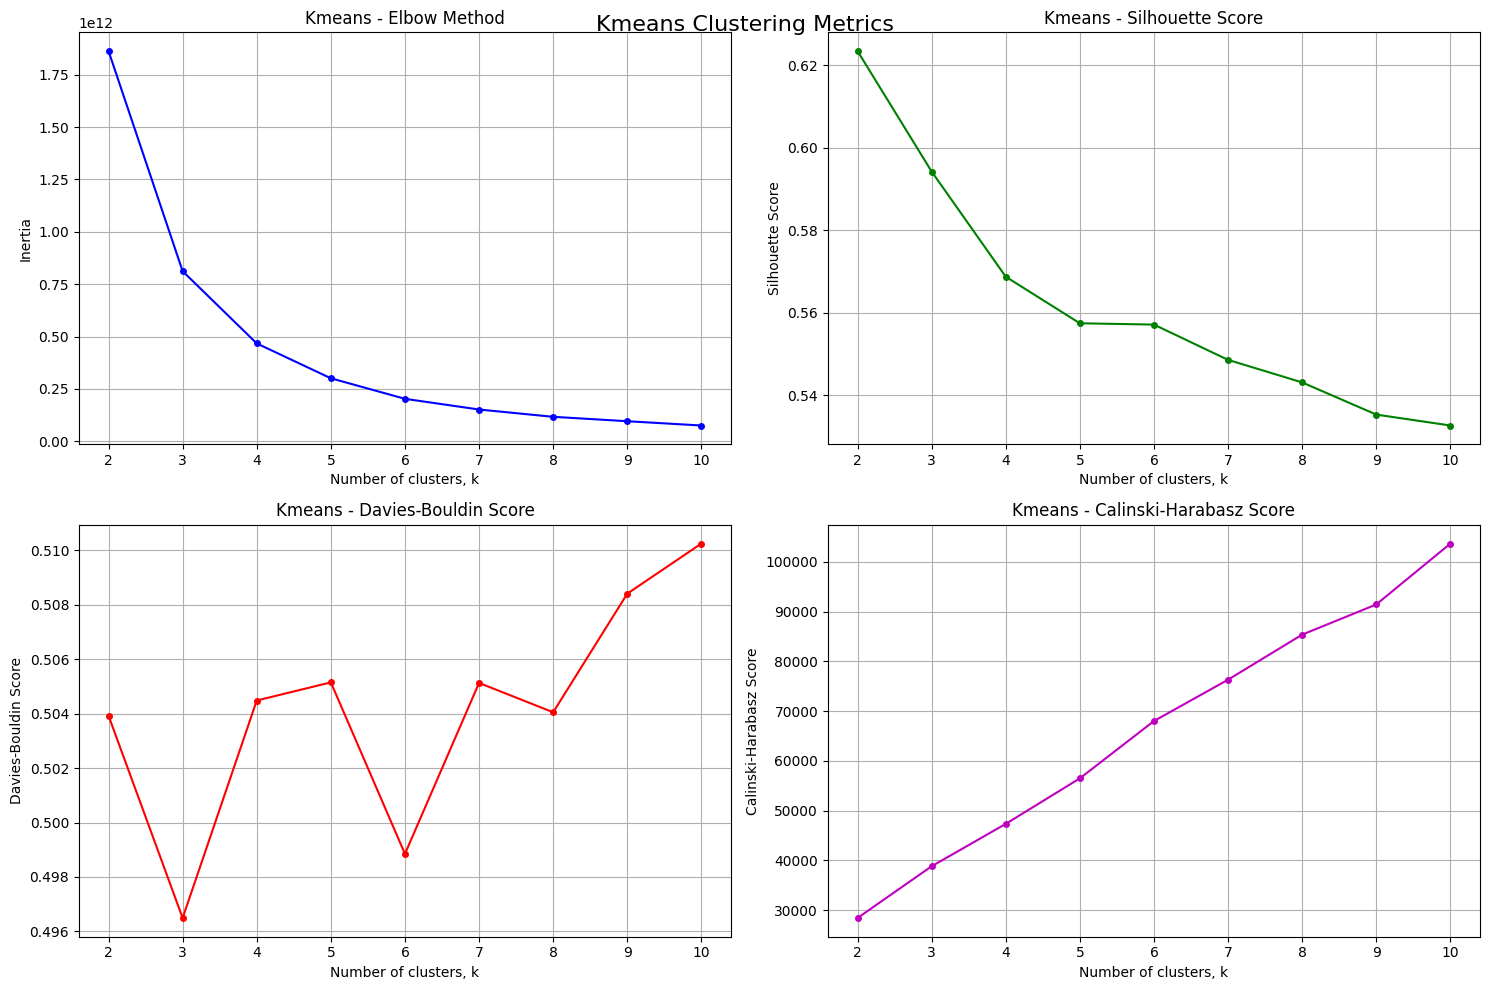

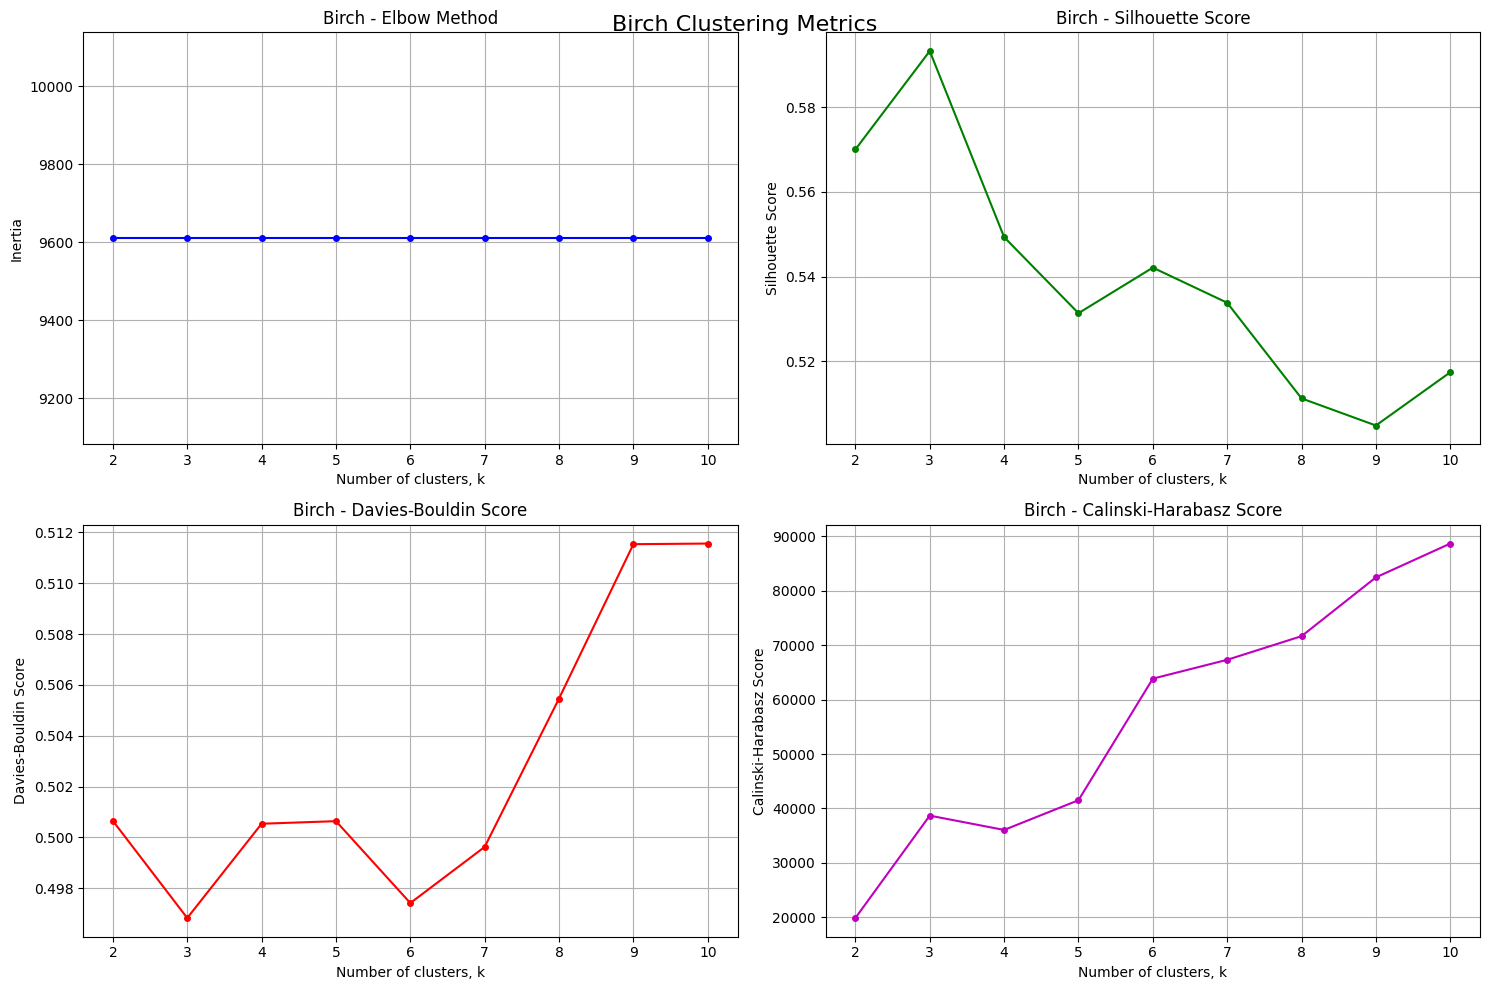

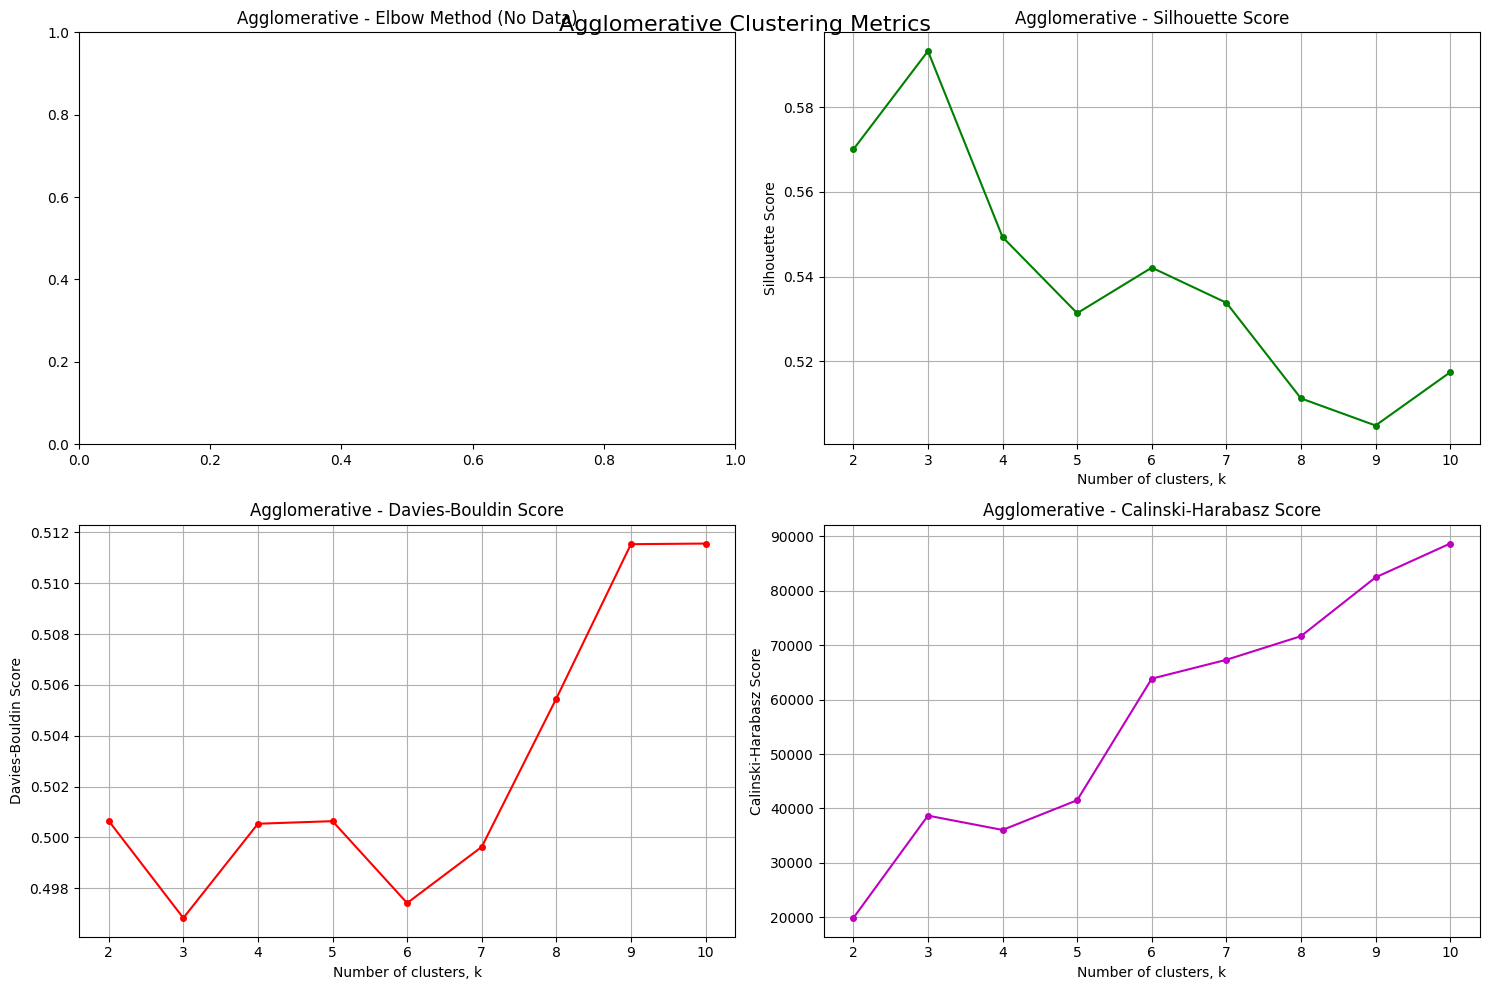

In [ ]:
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def plot_metrics_for_each_model(data, max_k=10):
    metrics = {
        'kmeans': {'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
        'birch': {'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
        'agglomerative': {'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
    }

    k_values = range(2, max_k + 1)

    for k in k_values:
        # KMeans
        kmeans = cluster.KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        metrics['kmeans']['inertia'].append(kmeans.inertia_)
        if len(set(labels)) > 1:
            metrics['kmeans']['silhouette'].append(silhouette_score(data, labels))
            metrics['kmeans']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['kmeans']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

        # Birch
        birch = cluster.Birch(n_clusters=k)
        labels = birch.fit_predict(data)
        if len(set(labels)) > 1:
            metrics['birch']['inertia'].append(birch.subcluster_centers_.shape[0])  # Approximation of inertia
            metrics['birch']['silhouette'].append(silhouette_score(data, labels))
            metrics['birch']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['birch']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

        # Agglomerative Clustering
        agg = cluster.AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(data)
        if len(set(labels)) > 1:
            metrics['agglomerative']['silhouette'].append(silhouette_score(data, labels))
            metrics['agglomerative']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['agglomerative']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

    # Tracé des métriques pour chaque modèle
    models = ['kmeans', 'birch', 'agglomerative']
    for model in models:
        plt.figure(figsize=(15, 10))

        # Elbow Method
        plt.subplot(2, 2, 1)
        if 'inertia' in metrics[model] and len(metrics[model]['inertia']) > 0:
            plt.plot(k_values, metrics[model]['inertia'], 'bo-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Inertia')
            plt.title(f'{model.capitalize()} - Elbow Method')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Elbow Method (No Data)')

        # Silhouette Score
        plt.subplot(2, 2, 2)
        if len(metrics[model]['silhouette']) > 0:
            plt.plot(k_values, metrics[model]['silhouette'], 'go-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Silhouette Score')
            plt.title(f'{model.capitalize()} - Silhouette Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Silhouette Score (No Data)')

        # Davies-Bouldin Score
        plt.subplot(2, 2, 3)
        if len(metrics[model]['davies_bouldin']) > 0:
            plt.plot(k_values, metrics[model]['davies_bouldin'], 'ro-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Davies-Bouldin Score')
            plt.title(f'{model.capitalize()} - Davies-Bouldin Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Davies-Bouldin Score (No Data)')

        # Calinski-Harabasz Score
        plt.subplot(2, 2, 4)
        if len(metrics[model]['calinski_harabasz']) > 0:
            plt.plot(k_values, metrics[model]['calinski_harabasz'], 'mo-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Calinski-Harabasz Score')
            plt.title(f'{model.capitalize()} - Calinski-Harabasz Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Calinski-Harabasz Score (No Data)')

        plt.tight_layout()
        plt.suptitle(f'{model.capitalize()} Clustering Metrics', fontsize=16)
        plt.show()

# Exemple d'utilisation avec des données fictives
# data = ... (votre jeu de données)
plot_metrics_for_each_model(rfm_sample)


Correspondance avec les sagments defini dans l'EDA
segment_order = ['Champions', 'Loyaux', 'Loyalistes potentiels', 'À réactiver', 'À risque', 'Perdus']

3 Correspond au 3 persona les plus presents et 6 correspond a tous les personas !


#### <a id='toc2_2_1_2_'></a>[Visualisation des clusters](#toc0_)

##### <a id='toc2_2_1_2_1_'></a>[Vue 2D](#toc0_)

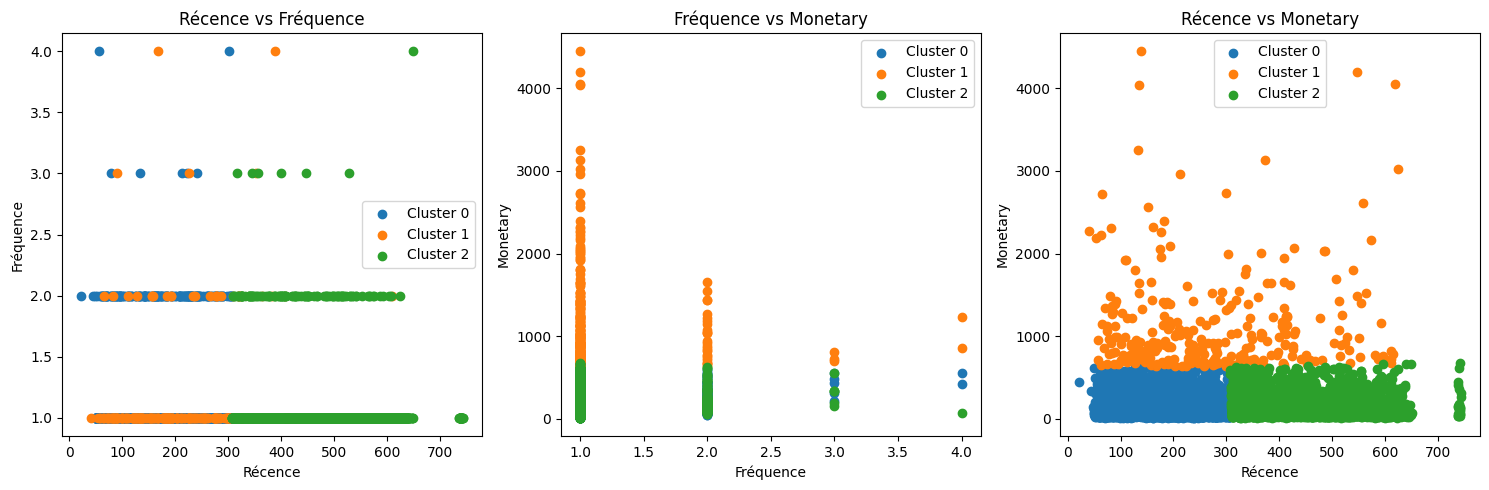

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supposons que 'rfm_sample' est votre rfm_sampleFrame RFM
# rfm_sample = pd.rfm_sampleFrame(...)

# Appliquer KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_sample['Cluster'] = kmeans.fit_predict(rfm_sample[['R', 'F', 'M']])

# Analyser les centres des clusters
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['R', 'F', 'M'])
# print("Centres des clusters :")
# print(centers)

# Calculer les statistiques descriptives pour chaque cluster
cluster_stats = rfm_sample.groupby('Cluster')[['R', 'F', 'M']].agg(['mean', 'median', 'std'])
# print("Statistiques descriptives des clusters :")
# print(cluster_stats)

# Visualiser les clusters
plt.figure(figsize=(15, 5))

# Graphique Récence vs Fréquence
plt.subplot(1, 3, 1)
for cluster in range(3):
    plt.scatter(rfm_sample[rfm_sample['Cluster'] == cluster]['R'], rfm_sample[rfm_sample['Cluster'] == cluster]['F'], label=f'Cluster {cluster}')
plt.xlabel('Récence')
plt.ylabel('Fréquence')
plt.title('Récence vs Fréquence')
plt.legend()

# Graphique Fréquence vs Monetary
plt.subplot(1, 3, 2)
for cluster in range(3):
    plt.scatter(rfm_sample[rfm_sample['Cluster'] == cluster]['F'], rfm_sample[rfm_sample['Cluster'] == cluster]['M'], label=f'Cluster {cluster}')
plt.xlabel('Fréquence')
plt.ylabel('Monetary')
plt.title('Fréquence vs Monetary')
plt.legend()

# Graphique Récence vs Monetary
plt.subplot(1, 3, 3)
for cluster in range(3):
    plt.scatter(rfm_sample[rfm_sample['Cluster'] == cluster]['R'], rfm_sample[rfm_sample['Cluster'] == cluster]['M'], label=f'Cluster {cluster}')
plt.xlabel('Récence')
plt.ylabel('Monetary')
plt.title('Récence vs Monetary')
plt.legend()

plt.tight_layout()
plt.show()


##### <a id='toc2_2_1_2_2_'></a>[Vue 3D](#toc0_)

In [ ]:
import plotly.express as px
import pandas as pd

# Supposons que 'data' est votre DataFrame RFM avec une colonne 'Cluster'
# data = pd.DataFrame(...)

# Créer un graphique 3D avec Plotly
fig = px.scatter_3d(rfm_sample, x='R', y='F', z='M', color='Cluster',
                    labels={'R': 'Récence', 'F': 'Fréquence', 'M': 'Monetary', 'Cluster': 'Cluster'},
                    title='Clustering RFM en 3D')

# Afficher le graphique
fig.show()


## <a id='toc2_3_'></a>[Benchmark RFMLS](#toc0_)

In [ ]:
# import des données
rfmls = pd.read_excel('RFMLS.xlsx')
rfmls = rfmls.drop(['customer_unique_id', 'Unnamed: 0'], axis=1).dropna()
rfmls.head()

,R,F,M,S,L
0,160,1,141.90,5,cajamar
1,163,1,27.19,4,osasco
2,585,1,86.22,3,sao jose
3,369,1,43.62,4,belem
4,336,1,196.89,5,sorocaba


In [ ]:
# On prend 10% des données pour gagner du temps d'execution
rfmls_sample = rfmls.sample(frac=0.1, random_state=42)
print(rfmls_sample.shape)

(9538, 5)


In [ ]:
import pandas as pd
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA

# Initialisation du FeatureHasher
hasher = FeatureHasher(n_features=50, input_type='string')

# Transformation de la colonne 'L' en une liste de listes
hashed_features = hasher.transform([[city] for city in rfmls_sample['L']])

# Initialisation du PCA
pca = PCA(n_components=1)  # Réduction à une seule dimension

# Application du PCA sur les caractéristiques hachées
hashed_features_pca = pca.fit_transform(hashed_features.toarray())

# Ajout de la composante principale au DataFrame original
rfmls_sample['L_pca'] = hashed_features_pca

print(rfmls_sample)


         R  F       M   S                   L     L_pca
72945  212  1  938.93   5           sao paulo -0.859466
572    460  1   43.91   5           silveiras  0.132610
73536  602  1  109.49   5           sao paulo -0.859466
40974  436  1   36.78   5         santo andre  0.139060
79128  145  1   49.32   5            rolandia  0.126389
...    ... ..     ...  ..                 ...       ...
8999    55  1  173.40   3           sao paulo -0.859466
94752  421  3  185.09  10  guaraguarabrasilia  0.125070
23072  125  1  108.72   5             pompeia  0.131796
33969  375  1  285.78   5     duque de caxias  0.289153
504    215  1   96.87   3           sao paulo -0.859466

[9538 rows x 6 columns]


### <a id='toc2_3_1_'></a>[Entrainement des modèle (Utilisation du multithreading)](#toc0_)

In [ ]:
rfmls_sample_train = rfmls_sample.drop('L', axis=1)

In [ ]:
results = []

# Exécution en parallèle avec joblib
results = Parallel(n_jobs=-1)(delayed(evaluate_algorithm)(name, algorithm, rfmls_sample_train)for name, algorithm in model_list.items())

# Création d'un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results)

In [ ]:
# Silhouette Score : Plus il est élevé, mieux c'est
# Davies-Bouldin Score : Plus il est faible, mieux c'est 
# Calinski-Harabasz Score : Plus il est élevé, mieux c'est

results_df.sort_values(by=['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'], ascending=[False, True, False])

,Algorithm,Time (s),Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
8,meanshift,35.276129,0.633797,0.502505,955.049796
0,kmeans,0.152655,0.510282,0.821844,5102.191103
4,birch,2.854434,0.457629,0.928762,4843.030665
1,minibatchkmeans,0.137522,0.445607,0.823991,4904.602596
5,agglomerative,2.391681,0.390427,0.733622,4970.038671
3,gmm,0.199010,0.026672,4.754962,877.930827
2,hdbscan,1.371526,NaN,NaN,NaN
6,dbscan,0.081096,NaN,NaN,NaN
7,optics,7.391598,NaN,NaN,NaN


#### <a id='toc2_3_1_1_'></a>[Find the best number of cluster (Plot metrics per number of cluster)](#toc0_)

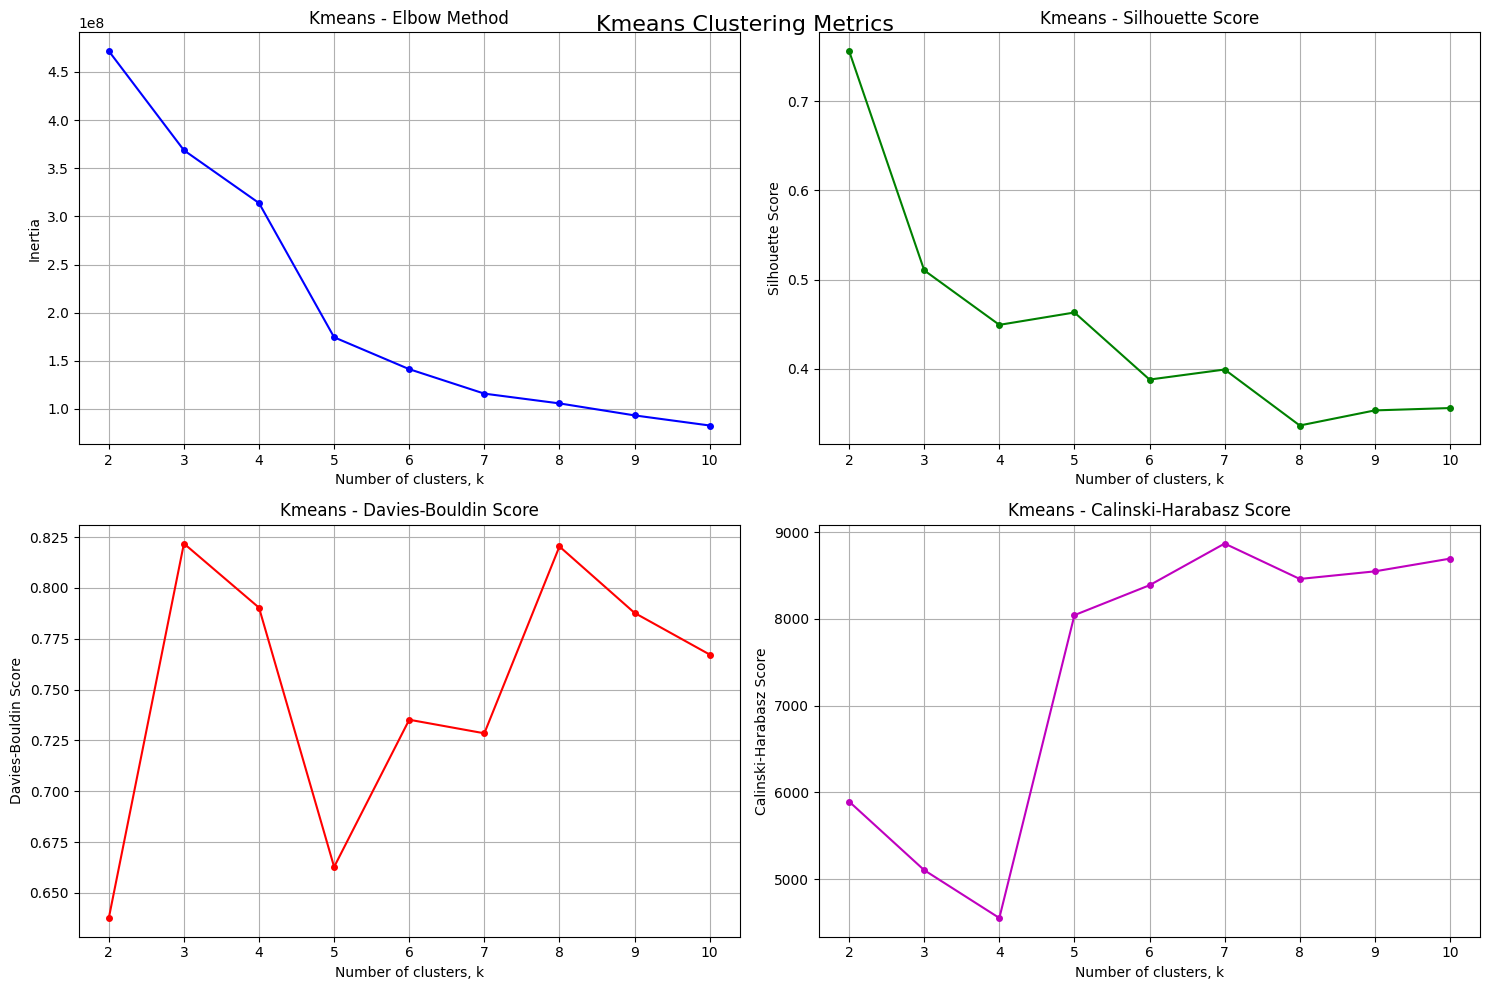

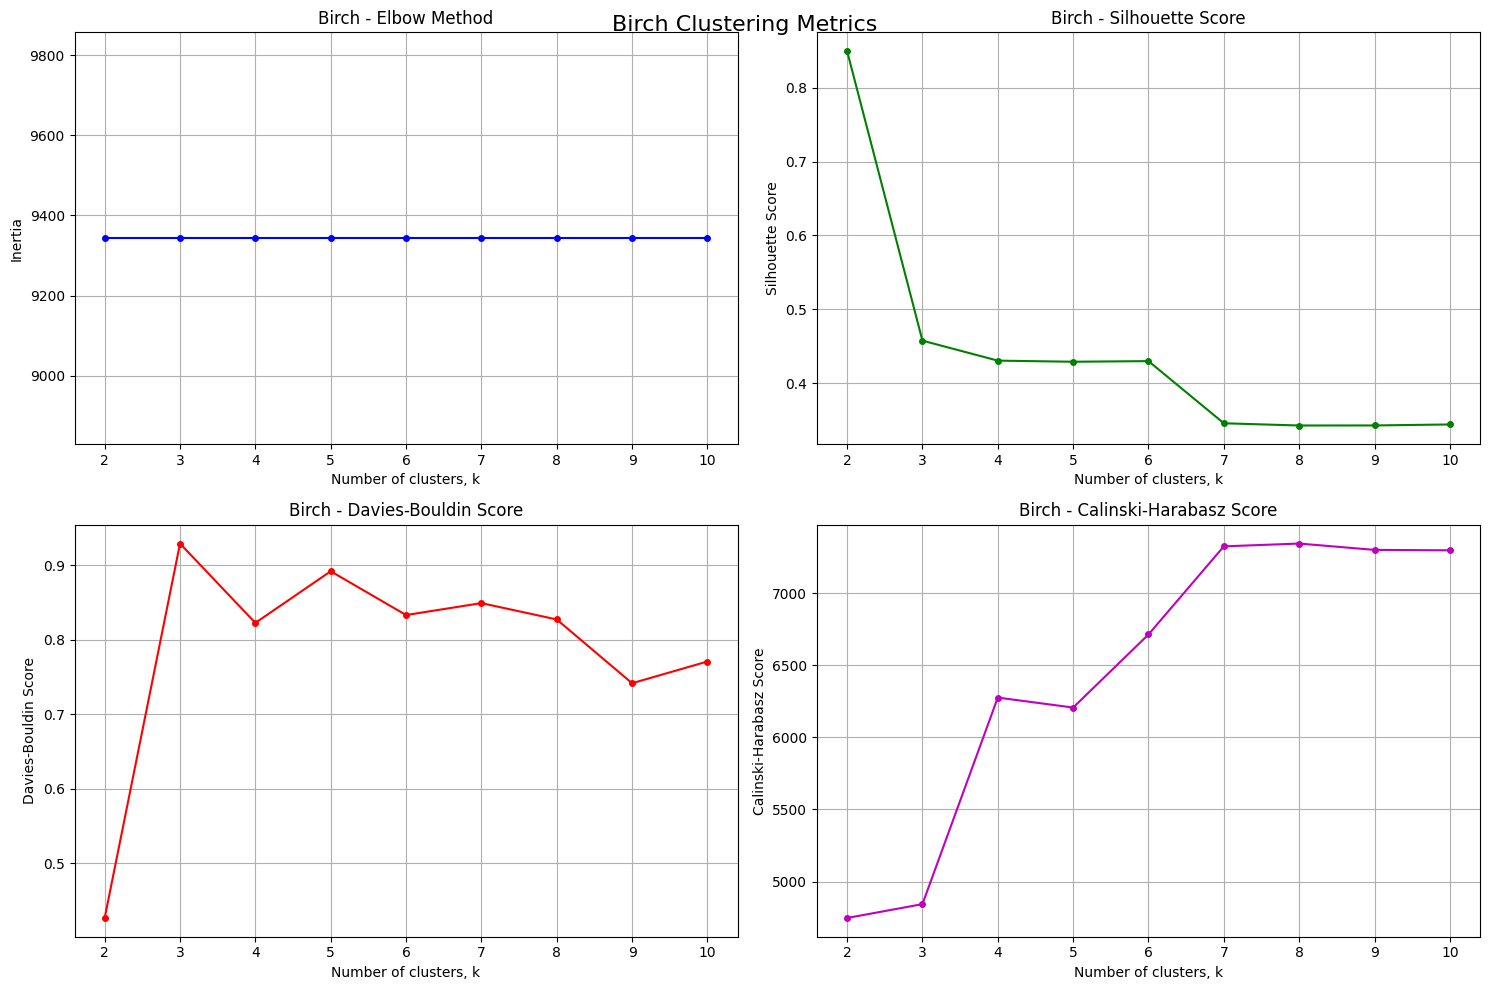

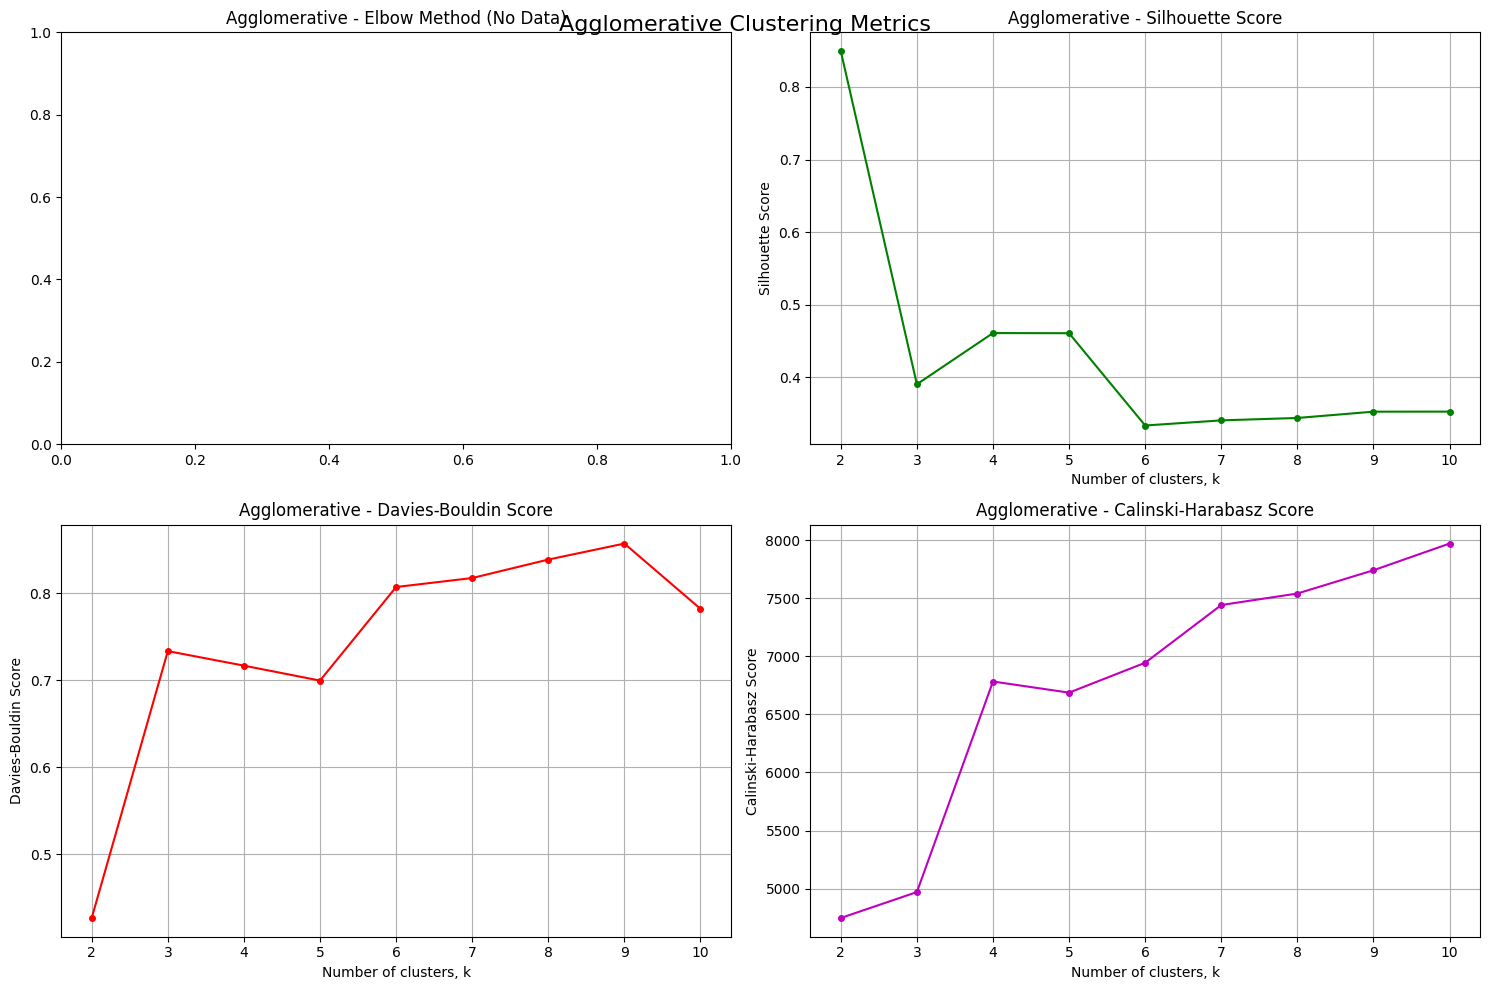

In [ ]:
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def plot_metrics_for_each_model(data, max_k=10):
    metrics = {
        'kmeans': {'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
        'birch': {'inertia': [], 'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
        'agglomerative': {'silhouette': [], 'davies_bouldin': [], 'calinski_harabasz': []},
    }

    k_values = range(2, max_k + 1)

    for k in k_values:
        # KMeans
        kmeans = cluster.KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        metrics['kmeans']['inertia'].append(kmeans.inertia_)
        if len(set(labels)) > 1:
            metrics['kmeans']['silhouette'].append(silhouette_score(data, labels))
            metrics['kmeans']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['kmeans']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

        # Birch
        birch = cluster.Birch(n_clusters=k)
        labels = birch.fit_predict(data)
        if len(set(labels)) > 1:
            metrics['birch']['inertia'].append(birch.subcluster_centers_.shape[0])  # Approximation of inertia
            metrics['birch']['silhouette'].append(silhouette_score(data, labels))
            metrics['birch']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['birch']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

        # Agglomerative Clustering
        agg = cluster.AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(data)
        if len(set(labels)) > 1:
            metrics['agglomerative']['silhouette'].append(silhouette_score(data, labels))
            metrics['agglomerative']['davies_bouldin'].append(davies_bouldin_score(data, labels))
            metrics['agglomerative']['calinski_harabasz'].append(calinski_harabasz_score(data, labels))

    # Tracé des métriques pour chaque modèle
    models = ['kmeans', 'birch', 'agglomerative']
    for model in models:
        plt.figure(figsize=(15, 10))

        # Elbow Method
        plt.subplot(2, 2, 1)
        if 'inertia' in metrics[model] and len(metrics[model]['inertia']) > 0:
            plt.plot(k_values, metrics[model]['inertia'], 'bo-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Inertia')
            plt.title(f'{model.capitalize()} - Elbow Method')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Elbow Method (No Data)')

        # Silhouette Score
        plt.subplot(2, 2, 2)
        if len(metrics[model]['silhouette']) > 0:
            plt.plot(k_values, metrics[model]['silhouette'], 'go-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Silhouette Score')
            plt.title(f'{model.capitalize()} - Silhouette Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Silhouette Score (No Data)')

        # Davies-Bouldin Score
        plt.subplot(2, 2, 3)
        if len(metrics[model]['davies_bouldin']) > 0:
            plt.plot(k_values, metrics[model]['davies_bouldin'], 'ro-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Davies-Bouldin Score')
            plt.title(f'{model.capitalize()} - Davies-Bouldin Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Davies-Bouldin Score (No Data)')

        # Calinski-Harabasz Score
        plt.subplot(2, 2, 4)
        if len(metrics[model]['calinski_harabasz']) > 0:
            plt.plot(k_values, metrics[model]['calinski_harabasz'], 'mo-', markersize=4)
            plt.xlabel('Number of clusters, k')
            plt.ylabel('Calinski-Harabasz Score')
            plt.title(f'{model.capitalize()} - Calinski-Harabasz Score')
            plt.grid(True)
        else:
            plt.title(f'{model.capitalize()} - Calinski-Harabasz Score (No Data)')

        plt.tight_layout()
        plt.suptitle(f'{model.capitalize()} Clustering Metrics', fontsize=16)
        plt.show()

# Exemple d'utilisation avec des données fictives
# data = ... (votre jeu de données)
plot_metrics_for_each_model(rfmls_sample_train)


Correspondance avec les sagments defini dans l'EDA
segment_order = ['Champions', 'Loyaux', 'Loyalistes potentiels', 'À réactiver', 'À risque', 'Perdus']

3 Correspond au 3 persona les plus presents et 6 correspond a tous les personas !

#### <a id='toc2_3_1_2_'></a>[Visualisation des clusters](#toc0_)

##### <a id='toc2_3_1_2_1_'></a>[Vue 2D](#toc0_)

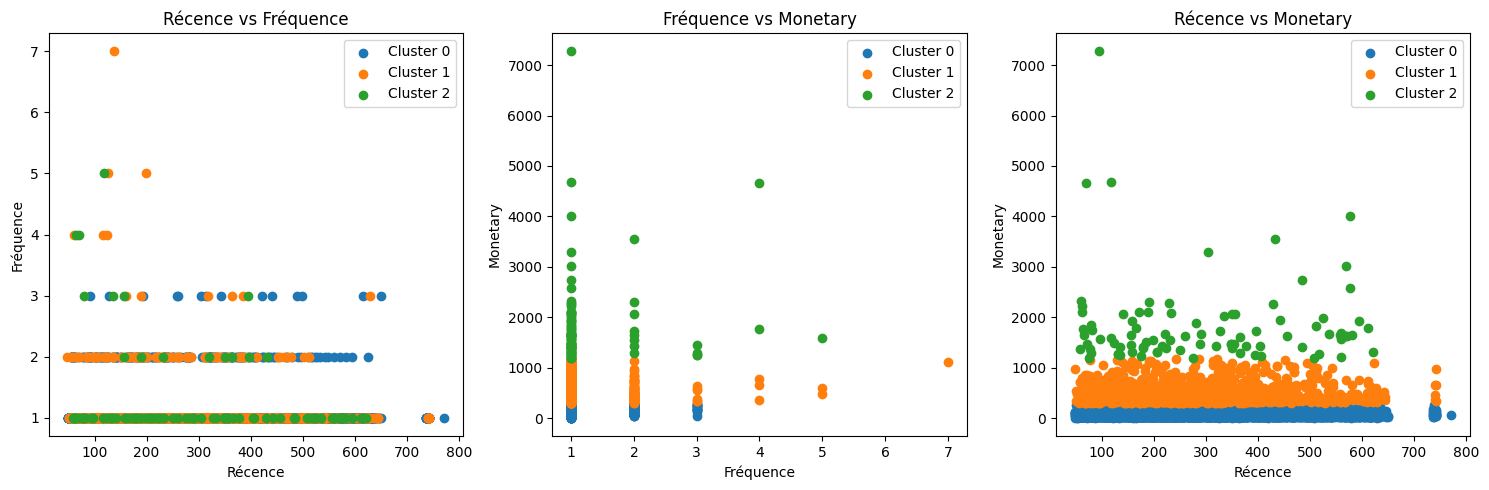

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Appliquer KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
rfmls_sample['Cluster'] = kmeans.fit_predict(rfmls_sample[['R', 'F', 'M']])

# Analyser les centres des clusters
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['R', 'F', 'M'])
# print("Centres des clusters :")
# print(centers)

# Calculer les statistiques descriptives pour chaque cluster
cluster_stats = rfmls_sample.groupby('Cluster')[['R', 'F', 'M']].agg(['mean', 'median', 'std'])
# print("Statistiques descriptives des clusters :")
# print(cluster_stats)

# Visualiser les clusters
plt.figure(figsize=(15, 5))

# Graphique Récence vs Fréquence
plt.subplot(1, 3, 1)
for cluster in range(3):
    plt.scatter(rfmls_sample[rfmls_sample['Cluster'] == cluster]['R'], rfmls_sample[rfmls_sample['Cluster'] == cluster]['F'], label=f'Cluster {cluster}')
plt.xlabel('Récence')
plt.ylabel('Fréquence')
plt.title('Récence vs Fréquence')
plt.legend()

# Graphique Fréquence vs Monetary
plt.subplot(1, 3, 2)
for cluster in range(3):
    plt.scatter(rfmls_sample[rfmls_sample['Cluster'] == cluster]['F'], rfmls_sample[rfmls_sample['Cluster'] == cluster]['M'], label=f'Cluster {cluster}')
plt.xlabel('Fréquence')
plt.ylabel('Monetary')
plt.title('Fréquence vs Monetary')
plt.legend()

# Graphique Récence vs Monetary
plt.subplot(1, 3, 3)
for cluster in range(3):
    plt.scatter(rfmls_sample[rfmls_sample['Cluster'] == cluster]['R'], rfmls_sample[rfmls_sample['Cluster'] == cluster]['M'], label=f'Cluster {cluster}')
plt.xlabel('Récence')
plt.ylabel('Monetary')
plt.title('Récence vs Monetary')
plt.legend()

plt.tight_layout()
plt.show()


##### <a id='toc2_3_1_2_2_'></a>[Vue 3D](#toc0_)

In [ ]:
import plotly.express as px
import pandas as pd

# Supposons que 'data' est votre DataFrame RFM avec une colonne 'Cluster'
# data = pd.DataFrame(...)

# Créer un graphique 3D avec Plotly
fig = px.scatter_3d(rfmls_sample, x='R', y='F', z='M', color='Cluster',
                    labels={'R': 'Récence', 'F': 'Fréquence', 'M': 'Monetary', 'Cluster': 'Cluster'},
                    title='Clustering RFM en 3D')

# Afficher le graphique
fig.show()


# <a id='toc3_'></a>[Entrainement du modèle selectioné](#toc0_)

#### <a id='toc3_1_1_1_'></a>[Entrainement Kmeans](#toc0_)

In [137]:
import pandas as pd
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA

In [138]:
# import des données
rfmls = pd.read_excel('RFMLS.xlsx')
rfmls = rfmls.drop(['customer_unique_id', 'Unnamed: 0'], axis=1).dropna()

In [139]:
def city_to_pca(data, column_name):
    """city to pca

    Args:
        data (Dataframe): current dataframe
        column_name: Name of the columns of the dataframe you want to convert

    Returns:
        Dataframe: Updated dataframe
    """
    # Initialisation du FeatureHasher
    hasher = FeatureHasher(n_features=50, input_type='string')

    # Transformation de la colonne 'L' en une liste de listes
    hashed_features = hasher.transform([[city] for city in data[column_name]])

    # Initialisation du PCA
    pca = PCA(n_components=1)  # Réduction à une seule dimension

    # Application du PCA sur les caractéristiques hachées
    hashed_features_pca = pca.fit_transform(hashed_features.toarray())

    # Ajout de la composante principale au DataFrame original
    data['L_pca'] = hashed_features_pca
    data = data.drop(column_name, axis=1)
    return data

city_to_pca(rfmls, 'L')

,R,F,M,S,L_pca
0,160,1,141.90,5,0.120652
1,163,1,27.19,4,0.127826
2,585,1,86.22,3,0.136825
3,369,1,43.62,4,0.133905
4,336,1,196.89,5,0.132717
...,...,...,...,...,...
95374,495,1,2067.42,5,0.125136
95375,310,1,84.58,4,0.127995
95376,617,1,112.46,5,0.123739
95377,168,1,133.69,5,0.126009


In [140]:
rfmls['L_pca'].max()

1.109147126587839

In [141]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

In [153]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction import FeatureHasher


# Fonction pour convertir la colonne 'L' en composante principale
def city_to_pca(data, column_name="L"):
    hasher = FeatureHasher(n_features=50, input_type="string")
    hashed_features = hasher.transform([[city] for city in data[column_name]])
    pca = PCA(n_components=1)
    hashed_features_pca = pca.fit_transform(hashed_features.toarray())
    result = data.copy()
    result["L"] = hashed_features_pca
    return result


# Fonction pour supprimer la colonne 'L'
def drop_column_L(X):
    if isinstance(X, pd.DataFrame):
        return X.drop(columns=["L"], errors="ignore")
    else:
        return np.delete(X, 0, axis=1)


# Encapsulation dans des FunctionTransformer
l_pca_transformer = FunctionTransformer(lambda X: city_to_pca(X, column_name="L"))
drop_L_transformer = FunctionTransformer(drop_column_L)

# Pipeline pour la colonne 'L'
l_pca = Pipeline(
    [
        ("Convert city to numerical", l_pca_transformer),
    ]
)

# ColumnTransformer pour prétraiter les colonnes
preprocessing = ColumnTransformer(
    transformers=[
        ("LocationGestion", l_pca, ["L"]),  
    ],
    remainder="passthrough",  
)

# Pipeline complet
pipe = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ("drop_L", drop_L_transformer),  
        ("standardize", StandardScaler()),  
        ("clustering", model_list["kmeans"]), 
    ]
)

In [154]:
# Visualisation de la pipeline
from sklearn import set_config
set_config(display='diagram')
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('LocationGestion',
                                                  Pipeline(steps=[('Convert '
                                                                   'city to '
                                                                   'numerical',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000211FAECBB00>))]),
                                                  ['L'])])),
                ('drop_L',
                 FunctionTransformer(func=<function drop_column_L at 0x00000211FAECB600>)),
                ('standardize', StandardScaler()),
                ('clustering', KMeans(n_clusters=3))])

In [155]:
pipe.fit(rfmls.sample(frac=0.1, random_state=42))

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('LocationGestion',
                                                  Pipeline(steps=[('Convert '
                                                                   'city to '
                                                                   'numerical',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000211FAECBB00>))]),
                                                  ['L'])])),
                ('drop_L',
                 FunctionTransformer(func=<function drop_column_L at 0x00000211FAECB600>)),
                ('standardize', StandardScaler()),
                ('clustering', KMeans(n_clusters=3))])

In [156]:
# Obtenir les étiquettes de cluster
labels = pipe.predict(rfmls)

# Analyser la distribution des clusters
import pandas as pd

cluster_distribution = pd.Series(labels).value_counts()
print(cluster_distribution)

0    77575
1    14823
2     2981
Name: count, dtype: int64


In [ ]:
import pandas as pd



# Appliquer le pipeline
transformed_data = pipe.named_steps['preprocessing'].transform(rfmls)

# Vérifier les colonnes restantes
# print(pd.DataFrame(transformed_data, columns=['L', 'R', 'F', 'M', 'S']))
transformed_data

array([[1.20653064e-01, 1.60000000e+02, 1.00000000e+00, 1.41900000e+02,
        5.00000000e+00, 1.20651829e-01],
       [1.27825147e-01, 1.63000000e+02, 1.00000000e+00, 2.71900000e+01,
        4.00000000e+00, 1.27825602e-01],
       [1.36823931e-01, 5.85000000e+02, 1.00000000e+00, 8.62200000e+01,
        3.00000000e+00, 1.36824885e-01],
       ...,
       [1.23737668e-01, 6.17000000e+02, 1.00000000e+00, 1.12460000e+02,
        5.00000000e+00, 1.23739111e-01],
       [1.26009510e-01, 1.68000000e+02, 1.00000000e+00, 1.33690000e+02,
        5.00000000e+00, 1.26009457e-01],
       [1.25239121e-01, 5.32000000e+02, 1.00000000e+00, 7.15600000e+01,
        5.00000000e+00, 1.25239085e-01]])

##### <a id='toc3_1_1_1_1_'></a>[Visualisation du modèle](#toc0_)

In [147]:
rfmls

,R,F,M,S,L,L_pca
0,160,1,141.90,5,cajamar,0.120652
1,163,1,27.19,4,osasco,0.127826
2,585,1,86.22,3,sao jose,0.136825
3,369,1,43.62,4,belem,0.133905
4,336,1,196.89,5,sorocaba,0.132717
...,...,...,...,...,...,...
95374,495,1,2067.42,5,sanharo,0.125136
95375,310,1,84.58,4,feira de santana,0.127995
95376,617,1,112.46,5,sinop,0.123739
95377,168,1,133.69,5,bom jesus do norte,0.126009


In [150]:
from yellowbrick.cluster import SilhouetteVisualizer

# Extraire le modèle de clustering de la pipeline
model = pipe.named_steps['clustering']

# Créer le visualiseur avec le modèle extrait
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

# Entraîner le visualiseur sur les données prétraitées
X_preprocessed = pipe.named_steps['preprocessing'].transform(rfmls)  # Prétraiter les données

print(X_preprocessed)
visualizer.fit(X_preprocessed)

# Afficher le résultat
visualizer.show()

[['cajamar' 0.12065286313950957 160.0 ... 141.9 5.0 0.12065182903053162]
 ['osasco' 0.1278255318271849 163.0 ... 27.19 4.0 0.1278256019378576]
 ['sao jose' 0.13682417766927346 585.0 ... 86.22 3.0 0.1368248854688453]
 ...
 ['sinop' 0.12373834868246053 617.0 ... 112.46 5.0 0.1237391114586721]
 ['bom jesus do norte' 0.12600954059605018 168.0 ... 133.69 5.0
  0.12600945731617483]
 ['campo largo' 0.12523914206965725 532.0 ... 71.56 5.0
  0.12523908518342639]]


ValueError: could not convert string to float: 'cajamar'

In [ ]:
x

# <a id='toc4_'></a>[Maintenace des Modèles](#toc0_)

## <a id='toc4_1_'></a>[Functions](#toc0_)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score, 
    adjusted_rand_score, 
    calinski_harabasz_score  # Ajout de cette métrique
)

def compute_and_store_rfm(dfs, scaler, initial_model, product_familly_res, period="M"):
    """
    Calcule et stocke les résultats RFM pour chaque période définie par 'period'.

    Paramètres :
        dfs (pd.DataFrame): DataFrame contenant les données avec les colonnes R, F, M et order_purchase_timestamp.
        scaler: Scaler pour normaliser les données RFM.
        initial_model: Modèle initial de clustering.
        product_familly_res (list): Liste pour stocker les résultats.
        period (str): Fréquence de découpage ('M' pour mois, 'W' pour semaine, 'Y' pour année).
    """
    # Définir les bornes temporelles selon la fréquence choisie
    min_date = dfs['order_purchase_timestamp'].min()
    max_date = dfs['order_purchase_timestamp'].max()
    date_range = pd.date_range(start=min_date, end=max_date, freq=period)

    for i in range(len(date_range) - 1):
        time_bound = date_range[i + 1]
        print(f"Traitement pour la période se terminant avant {time_bound}...")

        # Filtrer les données jusqu'à la date limite
        df_period = dfs[dfs['order_purchase_timestamp'] < time_bound]

        if df_period.empty:
            print(f"Période vide avant {time_bound}, sautée.")
            continue

        # Extraire les colonnes R, F, M
        rfm = df_period[['R', 'F', 'M']].copy()

        # Standardiser les données RFM
        rfm_scaled = scaler.transform(rfm)

        # Appliquer le modèle initial
        labels_before_fit = initial_model.predict(rfm_scaled)
        silh_before_fit = silhouette_score(rfm_scaled, labels_before_fit)
        db_before_fit = davies_bouldin_score(rfm_scaled, labels_before_fit)
        ch_before_fit = calinski_harabasz_score(rfm_scaled, labels_before_fit)  # Ajout ici

        # Ré-entraîner le modèle K-means
        fitted_model = KMeans(n_clusters=3, random_state=42).fit(rfm_scaled)
        labels_after_fit = fitted_model.predict(rfm_scaled)
        silh_after_fit = silhouette_score(rfm_scaled, labels_after_fit)
        db_after_fit = davies_bouldin_score(rfm_scaled, labels_after_fit)
        ch_after_fit = calinski_harabasz_score(rfm_scaled, labels_after_fit)  # Ajout ici

        # Calculer l'indice de Rand ajusté
        ari = adjusted_rand_score(labels_before_fit, labels_after_fit)

        # Stocker les résultats
        month_res = {
            'time_bound': time_bound,
            'dataframe': rfm,
            'prop_data_period': round((rfm.shape[0] / dfs.shape[0] * 100), 2),
            'labels_before_fit': labels_before_fit,
            'silh_before_fit': silh_before_fit,
            'db_before_fit': db_before_fit,
            'ch_before_fit': ch_before_fit,  # Ajout ici
            'fitted_model': fitted_model,
            'labels_after_fit': labels_after_fit,
            'silh_after_fit': silh_after_fit,
            'db_after_fit': db_after_fit,
            'ch_after_fit': ch_after_fit,  # Ajout ici
            'ari': ari
        }
        product_familly_res.append(month_res)

        # Afficher les résultats pour la période
        print(f"Période se terminant avant {time_bound}:")
        print(f"Proportion du jeu de données: {month_res['prop_data_period']}%")
        print(f"Indice de silhouette avant réentraînement: {silh_before_fit}")
        print(f"Indice Davies-Bouldin avant réentraînement: {db_before_fit}")
        print(f"Indice Calinski-Harabasz avant réentraînement: {ch_before_fit}")  # Ajout ici
        print(f"Indice de silhouette après réentraînement: {silh_after_fit}")
        print(f"Indice Davies-Bouldin après réentraînement: {db_after_fit}")
        print(f"Indice Calinski-Harabasz après réentraînement: {ch_after_fit}")  # Ajout ici
        print(f"Indice Rand ajusté: {ari}")
        print("-" * 150)
        print()


def calculate_ari_timelaps(product_familly_res):
    """
    Trace l'évolution de l'Indice Rand Ajusté (ARI) au cours du temps.

    Paramètres :
        product_familly_res (list): Liste contenant les résultats pour chaque période.
    """
    # Extraire les dates et les valeurs ARI
    dates = [res['time_bound'] for res in product_familly_res]
    ari_values = [res['ari'] for res in product_familly_res]

    # Tracer l'évolution de l'ARI
    plt.figure(figsize=(12, 6))
    plt.plot(dates, ari_values, marker='o', linestyle='-')
    plt.title('Évolution de l\'Indice Rand Ajusté (ARI) au cours du temps')
    plt.xlabel('Date')
    plt.ylabel('ARI')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# # Exemple d'utilisation
# if __name__ == "__main__":
#     # Initialisation des résultats
#     product_familly_res = []

#     # Charger votre DataFrame (remplacez ceci par votre propre code de chargement)
#     # dfs = pd.read_csv("votre_fichier.csv")
#     # Assurez-vous que votre DataFrame contient les colonnes suivantes :
#     # 'R', 'F', 'M', 'order_purchase_timestamp'

#     # Exemple : Simuler un DataFrame
#     data = {
#         'customer_unique_id': [f'cust_{i}' for i in range(1000)],
#         'R': [i % 365 for i in range(1000)],  # Recency
#         'F': [i % 50 + 1 for i in range(1000)],  # Frequency
#         'M': [i % 1000 + 100 for i in range(1000)],  # Monetary
#         'order_purchase_timestamp': pd.date_range('2020-01-01', periods=1000, freq='D')
#     }
#     dfs = pd.DataFrame(data)

#     # Normalisation des données RFM
#     from sklearn.preprocessing import StandardScaler
#     scaler = StandardScaler()

#     # Initialiser le modèle de clustering initial
#     initial_model = KMeans(n_clusters=3, random_state=42)

#     # Découper automatiquement en périodes (par exemple, par mois)
#     compute_and_store_rfm(dfs, scaler, initial_model, product_familly_res, period="M")

#     # Calculer et tracer l'évolution de l'ARI
#     calculate_ari_timelaps(product_familly_res)

## <a id='toc4_2_'></a>[ARI RFM](#toc0_)

link to sklearn doc [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score)

In [ ]:

rfm_segment = pd.read_excel('RFM.xlsx')

# Filter the dataset to include only relevant segments
rfm_segment = rfm_segment[rfm_segment['Segment'].isin(['Perdus', 'À réactiver', 'À risque'])]

### <a id='toc4_2_1_'></a>[labels_true](#toc0_)

In [ ]:
# Encode the 'Segment' column into numerical labels
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
true_labels = lb.fit_transform(rfm_segment['Segment'])

### <a id='toc4_2_2_'></a>[labels_pred](#toc0_)

In [ ]:
# 10%  du df
rfm_segment_sample_1 = rfm_segment.sample(frac=0.1, random_state=42)

# Drop non-numeric columns and prepare the feature set
rfm_segment_sample_1_predict = rfm_segment_sample_1.drop(
    ['Segment', 'Unnamed: 0', 'customer_unique_id'], axis=1
).reset_index(drop=True)

# Use KMeans to predict cluster labels
predicted_labels = model_list['kmeans'].fit_predict(rfm_segment_sample_1_predict)

### <a id='toc4_2_3_'></a>[Claculate ARI](#toc0_)

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Calculate the Adjusted Rand Index
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index: {ari}")

ValueError: Found input variables with inconsistent numbers of samples: [95185, 9518]

### <a id='toc4_2_4_'></a>[Plot ARI score /mois](#toc0_)

In [ ]:
# Initialisation des résultats
product_familly_res = []


scaler = StandardScaler()

# Initialiser le modèle de clustering initial
initial_model = KMeans(n_clusters=3, random_state=42)

# Découper automatiquement en périodes (par exemple, par mois)
compute_and_store_rfm(rfm_segment, scaler, initial_model, product_familly_res, period="M")

# Calculer et tracer l'évolution de l'ARI
calculate_ari_timelaps(product_familly_res)

## <a id='toc4_3_'></a>[ARI RFM LS](#toc0_)

link to sklearn doc [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score)

In [ ]:

rfm_segment = pd.read_excel('RFM.xlsx')

# Filter the dataset to include only relevant segments
rfm_segment = rfm_segment[rfm_segment['Segment'].isin(['Perdus', 'À réactiver', 'À risque'])]

##### <a id='toc4_3_1_1_1_'></a>[labels_true](#toc0_)

In [ ]:
# Encode the 'Segment' column into numerical labels
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
true_labels = lb.fit_transform(rfm_segment['Segment'])

##### <a id='toc4_3_1_1_2_'></a>[labels_pred](#toc0_)

In [ ]:
# 10%  du df
rfm_segment_sample_1 = rfm_segment.sample(frac=0.1, random_state=42)

# Drop non-numeric columns and prepare the feature set
rfm_segment_sample_1_predict = rfm_segment_sample_1.drop(
    ['Segment', 'Unnamed: 0', 'customer_unique_id'], axis=1
).reset_index(drop=True)

# Use KMeans to predict cluster labels
predicted_labels = model_list['kmeans'].fit_predict(rfm_segment_sample_1_predict)

##### <a id='toc4_3_1_1_3_'></a>[Claculate ARI](#toc0_)

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Calculate the Adjusted Rand Index
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index: {ari}")

### <a id='toc4_3_2_'></a>[Plot ARI score /mois](#toc0_)